In [ ]:
# installing and importing protparam library
!pip install biopython
from Bio.SeqUtils import ProtParam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.1 MB/s eta 0:00:00


In [ ]:
# importing necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import copy
import numpy as np
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
df = pd.read_csv('/content/phospho_dataset.csv') # loading the dataset

In [ ]:
df # displaying the dataset

,Extracted_Sequence,Target
0,kfledmsyltlkanc,0
1,snpsyrtstqevkle,0
2,plvdpsvygygvqkr,0
3,kinllihvgcalerm,1
4,rirpqdsycphcgyy,1
...,...,...
57230,talyftfssltsvgf,1
57231,lhfirfpscamhrfi,0
57232,rvlnrkssiiivnrn,0
57233,pdqappsrrrrsdwa,1


In [ ]:
# function to split amino_acid_composition feature to multiple features
def expand_amino_acid_composition(data):
    return pd.Series(data['amino_acid_composition'])
# function to split secondary_structure_fraction feature to multiple features
def expand_secondary_structure_fraction(data):
    return pd.Series(data['secondary_structure_fraction'])

In [ ]:
# function to extract features using protparam (approach2)
def get_features(data):
  features = []
  for seq in data['Extracted_Sequence']:
    try:

      aa_comp = ProtParam.ProteinAnalysis(str(seq)).get_amino_acids_percent()
      mol_wt = ProtParam.ProteinAnalysis(str(seq)).molecular_weight()
      aroma = ProtParam.ProteinAnalysis(str(seq)).aromaticity()
      insta_ind = ProtParam.ProteinAnalysis(str(seq)).instability_index()
      isoelec_pnt = ProtParam.ProteinAnalysis(str(seq)).isoelectric_point()
      sec_struc_frac = ProtParam.ProteinAnalysis(str(seq)).secondary_structure_fraction()
      feature = {
          "amino_acid_composition": aa_comp,
          "molecular_weight": mol_wt,
          "aromaticity": aroma,
          "instability_index": insta_ind,
          "isoelectric_point": isoelec_pnt,
          "secondary_structure_fraction": sec_struc_frac
      }
    except:
      pass
    features.append(feature)
  features = pd.DataFrame(features)
  amino_comp_df = features.apply(expand_amino_acid_composition, axis=1)
  secondary_structure_fraction_df = features.apply(expand_secondary_structure_fraction, axis=1)
  secondary_structure_fraction_df.columns = ['secondary_structure_fraction_x','secondary_structure_fraction_y','secondary_structure_fraction_z']
  features = pd.concat([features, amino_comp_df, secondary_structure_fraction_df], axis=1)
  features.drop(['amino_acid_composition', 'secondary_structure_fraction'], axis=1, inplace=True)
  return features, data['Target']

In [ ]:
# function to compute amiono acid composition
def compute_aa_composition_features(data):
    features = []
    for seq in data['Extracted_Sequence']:

        aa_comp = ProtParam.ProteinAnalysis(str(seq)).get_amino_acids_percent()

        features.append(list(aa_comp.values()))

    return np.array(features)



In [ ]:
# function to extract features using protparam (approach1)
def extract_feature(df):
  df['length'] = df['Extracted_Sequence'].apply(len)
  df_aa = compute_aa_composition_features(df)
  vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2,2))
  df_vectorized = vectorizer.fit_transform(df['Extracted_Sequence'])
  df_vectorized = np.hstack([df_vectorized.toarray(), df['length'].values.reshape(-1,1), df_aa])
  df_target = df['Target']
  return df_vectorized, df_target

# **Protparam dataset**

In [ ]:
# extracting features and target using protparam approach2
data, target  = get_features(df)
data

,molecular_weight,aromaticity,instability_index,isoelectric_point,A,C,D,E,F,G,...,Q,R,S,T,V,W,Y,secondary_structure_fraction_x,secondary_structure_fraction_y,secondary_structure_fraction_z
0,1776.0817,0.133333,43.886667,6.061162,0.066667,0.066667,0.066667,0.066667,0.066667,0.000000,...,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.066667,0.533333,0.200000,0.400000
1,1738.8498,0.066667,9.213333,6.005972,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,...,0.066667,0.066667,0.200000,0.133333,0.066667,0.000000,0.066667,0.266667,0.333333,0.333333
2,1677.8972,0.133333,11.880000,8.902649,0.000000,0.000000,0.066667,0.000000,0.000000,0.133333,...,0.066667,0.066667,0.066667,0.000000,0.200000,0.000000,0.133333,0.133333,0.400000,0.400000
3,1710.1163,0.000000,6.240000,8.231146,0.066667,0.066667,0.000000,0.066667,0.000000,0.066667,...,0.000000,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.466667,0.133333,0.400000
4,1858.0646,0.200000,76.100000,8.042447,0.000000,0.133333,0.066667,0.000000,0.000000,0.066667,...,0.066667,0.133333,0.066667,0.000000,0.000000,0.000000,0.200000,0.000000,0.333333,0.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57230,1640.8289,0.266667,24.740000,5.184876,0.066667,0.000000,0.000000,0.000000,0.200000,0.066667,...,0.000000,0.000000,0.200000,0.200000,0.066667,0.000000,0.066667,0.200000,0.266667,0.666667
57231,1875.2688,0.200000,88.020000,10.352349,0.066667,0.066667,0.000000,0.000000,0.200000,0.000000,...,0.000000,0.133333,0.066667,0.000000,0.000000,0.000000,0.000000,0.200000,0.133333,0.400000
57232,1782.0995,0.000000,24.740000,11.999968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.200000,0.133333,0.000000,0.133333,0.000000,0.000000,0.133333,0.333333,0.400000
57233,1794.9280,0.066667,189.500000,11.523289,0.133333,0.000000,0.133333,0.000000,0.000000,0.000000,...,0.066667,0.266667,0.133333,0.000000,0.000000,0.066667,0.000000,0.133333,0.466667,0.066667


In [ ]:
# function to split data and pre-process its shape
def split_data(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
  x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
  x_val = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])
  x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
# function to create RNN model
def create_model(data):
  model = tf.keras.Sequential([
      tf.keras.layers.SimpleRNN(64, input_shape=(1, data.shape[2]), return_sequences=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.SimpleRNN(64, return_sequences=True),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.SimpleRNN(32),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])
  return model

In [ ]:
# function to compile model and fit model
def train(model, opt, epoch, batch, x_train, y_train, x_val, y_val):
  model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  hist = model.fit(x_train, y_train, epochs=epoch, batch_size=batch, validation_data=(x_val, y_val), callbacks=[early_stopping])
  return  model, hist

In [ ]:
# function to evaluate score
def evaluate_score(model, x_test, y_test):
  _, acc, prec, rec = model.evaluate(x_test, y_test)
  try:
    f1_score = (2*prec*rec)/(prec+rec)
  except:
    f1_score = 0
  print("Accuracy  :", acc)
  print("Precision :", prec)
  print("Recall    :", rec)
  print("F1-Score  :", f1_score)

In [ ]:
# function to create plot
def plot(hist):
  plt.plot(hist[1].history['accuracy'])
  plt.plot(hist[1].history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend([' Train', 'Test'], loc='upper left')
  plt.show()

In [ ]:
# preprocessing the data and creating model
x = data.values
sc = StandardScaler()
x = sc.fit_transform(x)
y = target.values
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)
model = create_model(x_train)

In [ ]:
# training model and evaluating scores with different batch size and optimizers and iterations

Epoch 1/100
501/501 [==============================] - 7s 7ms/step - loss: 0.7493 - accuracy: 0.4971 - precision: 0.4799 - recall: 0.6862 - val_loss: 0.7327 - val_accuracy: 0.4996 - val_precision: 0.4792 - val_recall: 0.7415
Epoch 2/100
501/501 [==============================] - 4s 7ms/step - loss: 0.7474 - accuracy: 0.5066 - precision: 0.4868 - recall: 0.6934 - val_loss: 0.7312 - val_accuracy: 0.5044 - val_precision: 0.4824 - val_recall: 0.7365
Epoch 3/100
501/501 [==============================] - 4s 7ms/step - loss: 0.7481 - accuracy: 0.4991 - precision: 0.4811 - recall: 0.6795 - val_loss: 0.7298 - val_accuracy: 0.5083 - val_precision: 0.4849 - val_recall: 0.7314
Epoch 4/100
501/501 [==============================] - 3s 5ms/step - loss: 0.7446 - accuracy: 0.5054 - precision: 0.4856 - recall: 0.6733 - val_loss: 0.7284 - val_accuracy: 0.5120 - val_precision: 0.4874 - val_recall: 0.7261
Epoch 5/100
501/501 [==============================] - 3s 6ms/step - loss: 0.7437 - accuracy: 0.5067

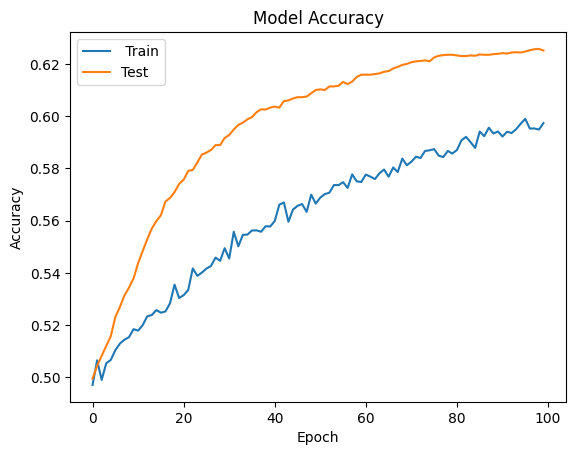

Epoch 1/100
251/251 [==============================] - 6s 10ms/step - loss: 0.6950 - accuracy: 0.6023 - precision_1: 0.5894 - recall_1: 0.5397 - val_loss: 0.6800 - val_accuracy: 0.6251 - val_precision_1: 0.6159 - val_recall_1: 0.5387
Epoch 2/100
251/251 [==============================] - 2s 10ms/step - loss: 0.6957 - accuracy: 0.5929 - precision_1: 0.5783 - recall_1: 0.5319 - val_loss: 0.6798 - val_accuracy: 0.6256 - val_precision_1: 0.6167 - val_recall_1: 0.5385
Epoch 3/100
251/251 [==============================] - 2s 8ms/step - loss: 0.6958 - accuracy: 0.5962 - precision_1: 0.5824 - recall_1: 0.5339 - val_loss: 0.6796 - val_accuracy: 0.6259 - val_precision_1: 0.6171 - val_recall_1: 0.5385
Epoch 4/100
251/251 [==============================] - 2s 7ms/step - loss: 0.6969 - accuracy: 0.5944 - precision_1: 0.5808 - recall_1: 0.5285 - val_loss: 0.6795 - val_accuracy: 0.6261 - val_precision_1: 0.6174 - val_recall_1: 0.5387
Epoch 5/100
251/251 [==============================] - 2s 6ms/step

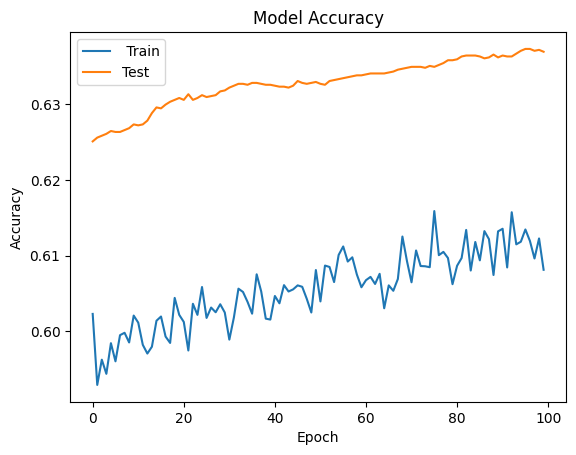

Epoch 1/100
126/126 [==============================] - 5s 14ms/step - loss: 0.6888 - accuracy: 0.6100 - precision_2: 0.6002 - recall_2: 0.5393 - val_loss: 0.6687 - val_accuracy: 0.6370 - val_precision_2: 0.6277 - val_recall_2: 0.5602
Epoch 2/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6885 - accuracy: 0.6155 - precision_2: 0.6079 - recall_2: 0.5395 - val_loss: 0.6687 - val_accuracy: 0.6367 - val_precision_2: 0.6274 - val_recall_2: 0.5600
Epoch 3/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6871 - accuracy: 0.6134 - precision_2: 0.6049 - recall_2: 0.5395 - val_loss: 0.6686 - val_accuracy: 0.6368 - val_precision_2: 0.6275 - val_recall_2: 0.5602
Epoch 4/100
126/126 [==============================] - 1s 8ms/step - loss: 0.6868 - accuracy: 0.6126 - precision_2: 0.6035 - recall_2: 0.5401 - val_loss: 0.6686 - val_accuracy: 0.6367 - val_precision_2: 0.6273 - val_recall_2: 0.5602
Epoch 5/100
126/126 [==============================] - 1s 9ms/step 

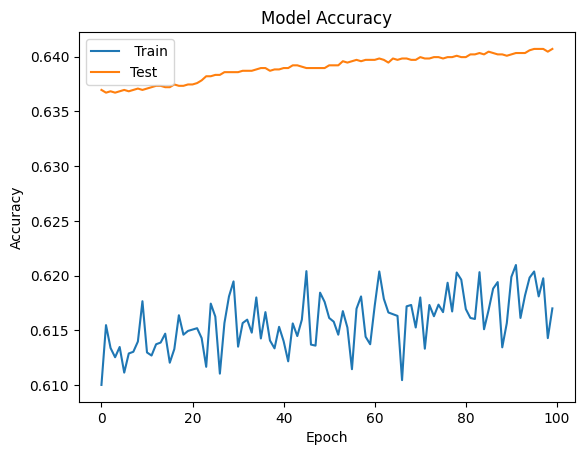

Epoch 1/100
63/63 [==============================] - 6s 35ms/step - loss: 0.6850 - accuracy: 0.6174 - precision_3: 0.6086 - recall_3: 0.5477 - val_loss: 0.6649 - val_accuracy: 0.6410 - val_precision_3: 0.6303 - val_recall_3: 0.5719
Epoch 2/100
63/63 [==============================] - 1s 15ms/step - loss: 0.6825 - accuracy: 0.6206 - precision_3: 0.6130 - recall_3: 0.5485 - val_loss: 0.6649 - val_accuracy: 0.6410 - val_precision_3: 0.6303 - val_recall_3: 0.5719
Epoch 3/100
63/63 [==============================] - 1s 12ms/step - loss: 0.6834 - accuracy: 0.6179 - precision_3: 0.6104 - recall_3: 0.5430 - val_loss: 0.6648 - val_accuracy: 0.6408 - val_precision_3: 0.6301 - val_recall_3: 0.5719
Epoch 4/100
63/63 [==============================] - 1s 12ms/step - loss: 0.6840 - accuracy: 0.6151 - precision_3: 0.6056 - recall_3: 0.5468 - val_loss: 0.6648 - val_accuracy: 0.6410 - val_precision_3: 0.6303 - val_recall_3: 0.5719
Epoch 5/100
63/63 [==============================] - 1s 12ms/step - loss

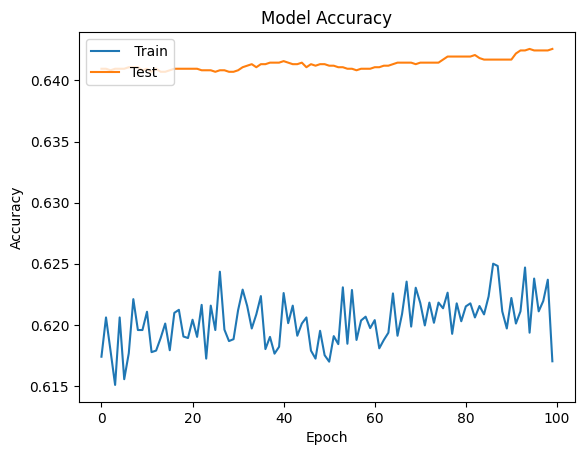

In [ ]:
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adadelta", 100, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)

In [ ]:
# extracting features and target using protparam approach1
data, target  = extract_feature(df)
data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06666667],
       [0.        , 0.        , 0.        , ..., 0.06666667, 0.        ,
        0.06666667],
       [0.        , 0.        , 0.        , ..., 0.2       , 0.        ,
        0.13333333],
       ...,
       [0.        , 0.        , 0.        , ..., 0.13333333, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.06666667,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# preprocessing the data and create model
x = data
sc = StandardScaler()
x = sc.fit_transform(x)
y = target
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)
model = create_model(x_train)

In [ ]:
# training model and evaluating scores with different batch size and optimizers and iterations

Epoch 1/100
501/501 [==============================] - 9s 9ms/step - loss: 0.7277 - accuracy: 0.5175 - precision_4: 0.4841 - recall_4: 0.2211 - val_loss: 0.7230 - val_accuracy: 0.5155 - val_precision_4: 0.4665 - val_recall_4: 0.2107
Epoch 2/100
501/501 [==============================] - 3s 6ms/step - loss: 0.7272 - accuracy: 0.5182 - precision_4: 0.4857 - recall_4: 0.2199 - val_loss: 0.7229 - val_accuracy: 0.5164 - val_precision_4: 0.4688 - val_recall_4: 0.2131
Epoch 3/100
501/501 [==============================] - 3s 6ms/step - loss: 0.7269 - accuracy: 0.5166 - precision_4: 0.4819 - recall_4: 0.2207 - val_loss: 0.7227 - val_accuracy: 0.5163 - val_precision_4: 0.4686 - val_recall_4: 0.2142
Epoch 4/100
501/501 [==============================] - 5s 10ms/step - loss: 0.7281 - accuracy: 0.5132 - precision_4: 0.4737 - recall_4: 0.2131 - val_loss: 0.7226 - val_accuracy: 0.5165 - val_precision_4: 0.4693 - val_recall_4: 0.2150
Epoch 5/100
501/501 [==============================] - 3s 6ms/step 

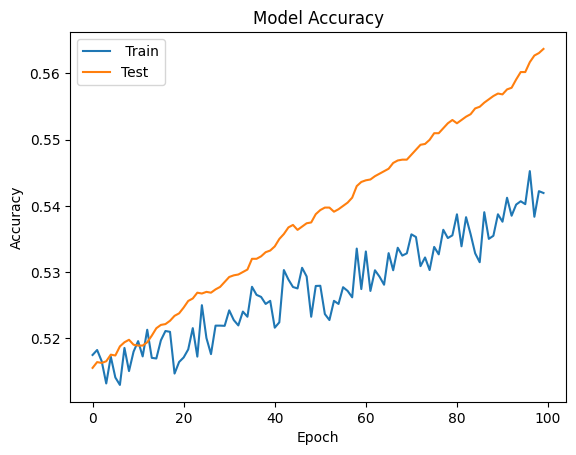

Epoch 1/100
251/251 [==============================] - 7s 10ms/step - loss: 0.7150 - accuracy: 0.5412 - precision_5: 0.5314 - recall_5: 0.2988 - val_loss: 0.7118 - val_accuracy: 0.5643 - val_precision_5: 0.5580 - val_recall_5: 0.3535
Epoch 2/100
251/251 [==============================] - 2s 8ms/step - loss: 0.7159 - accuracy: 0.5386 - precision_5: 0.5270 - recall_5: 0.2924 - val_loss: 0.7117 - val_accuracy: 0.5643 - val_precision_5: 0.5579 - val_recall_5: 0.3543
Epoch 3/100
251/251 [==============================] - 2s 8ms/step - loss: 0.7148 - accuracy: 0.5456 - precision_5: 0.5391 - recall_5: 0.3063 - val_loss: 0.7116 - val_accuracy: 0.5655 - val_precision_5: 0.5597 - val_recall_5: 0.3559
Epoch 4/100
251/251 [==============================] - 3s 10ms/step - loss: 0.7156 - accuracy: 0.5410 - precision_5: 0.5311 - recall_5: 0.2974 - val_loss: 0.7115 - val_accuracy: 0.5657 - val_precision_5: 0.5600 - val_recall_5: 0.3567
Epoch 5/100
251/251 [==============================] - 3s 13ms/ste

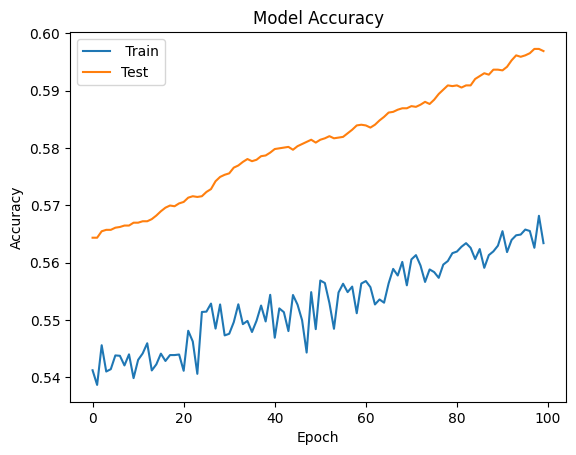

Epoch 1/100
126/126 [==============================] - 6s 15ms/step - loss: 0.7058 - accuracy: 0.5633 - precision_6: 0.5616 - recall_6: 0.3722 - val_loss: 0.6992 - val_accuracy: 0.5968 - val_precision_6: 0.5881 - val_recall_6: 0.4758
Epoch 2/100
126/126 [==============================] - 1s 10ms/step - loss: 0.7047 - accuracy: 0.5704 - precision_6: 0.5726 - recall_6: 0.3810 - val_loss: 0.6991 - val_accuracy: 0.5969 - val_precision_6: 0.5881 - val_recall_6: 0.4766
Epoch 3/100
126/126 [==============================] - 1s 9ms/step - loss: 0.7046 - accuracy: 0.5644 - precision_6: 0.5636 - recall_6: 0.3726 - val_loss: 0.6989 - val_accuracy: 0.5972 - val_precision_6: 0.5883 - val_recall_6: 0.4774
Epoch 4/100
126/126 [==============================] - 1s 9ms/step - loss: 0.7047 - accuracy: 0.5664 - precision_6: 0.5663 - recall_6: 0.3769 - val_loss: 0.6988 - val_accuracy: 0.5965 - val_precision_6: 0.5872 - val_recall_6: 0.4782
Epoch 5/100
126/126 [==============================] - 1s 10ms/ste

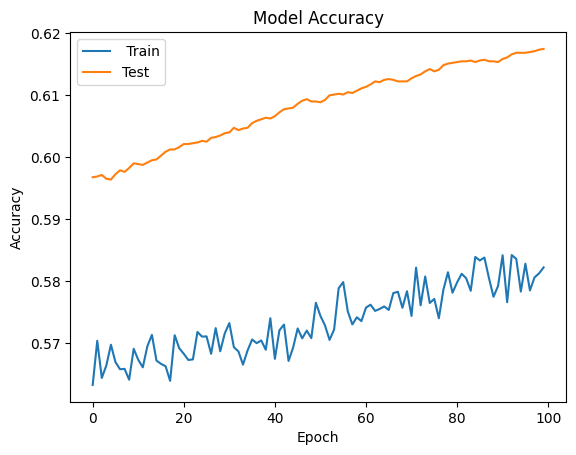

Epoch 1/100
63/63 [==============================] - 5s 25ms/step - loss: 0.6958 - accuracy: 0.5841 - precision_7: 0.5846 - recall_7: 0.4338 - val_loss: 0.6876 - val_accuracy: 0.6180 - val_precision_7: 0.6008 - val_recall_7: 0.5592
Epoch 2/100
63/63 [==============================] - 1s 15ms/step - loss: 0.6965 - accuracy: 0.5838 - precision_7: 0.5831 - recall_7: 0.4382 - val_loss: 0.6875 - val_accuracy: 0.6181 - val_precision_7: 0.6009 - val_recall_7: 0.5597
Epoch 3/100
63/63 [==============================] - 1s 16ms/step - loss: 0.6962 - accuracy: 0.5823 - precision_7: 0.5808 - recall_7: 0.4369 - val_loss: 0.6875 - val_accuracy: 0.6185 - val_precision_7: 0.6011 - val_recall_7: 0.5610
Epoch 4/100
63/63 [==============================] - 1s 16ms/step - loss: 0.6968 - accuracy: 0.5825 - precision_7: 0.5811 - recall_7: 0.4374 - val_loss: 0.6874 - val_accuracy: 0.6186 - val_precision_7: 0.6011 - val_recall_7: 0.5616
Epoch 5/100
63/63 [==============================] - 1s 15ms/step - loss

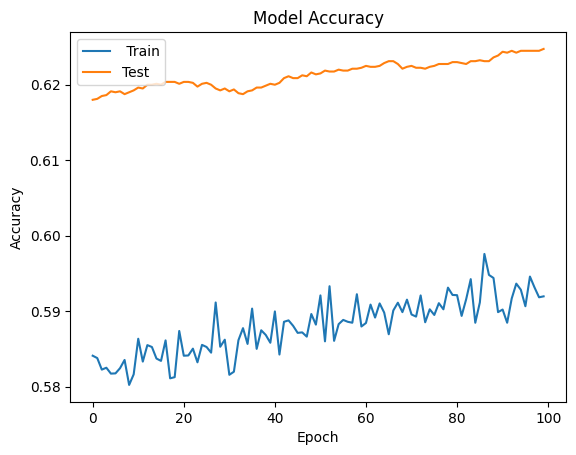

In [ ]:
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adadelta", 100, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)

# **pFeature dataset**

In [ ]:
# loading features from pFeature
aac = pd.read_csv("/content/drive/MyDrive/AAC_feature.csv")
dpc = pd.read_csv("/content/drive/MyDrive/DPC_feature.csv")
struct_pc = pd.read_csv("/content/drive/MyDrive/final_physico-chemical_result_structural.csv")
struct_pc = struct_pc.drop(['ID'],axis=1)
target = pd.read_csv("/content/drive/MyDrive/target.csv")

In [ ]:
# preprocessing the data and creating model with amino acid composition features
x = aac.values
sc = StandardScaler()
x = sc.fit_transform(x)
y = target.values
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)
model = create_model(x_train)

Epoch 1/200
544/544 [==============================] - 8s 7ms/step - loss: 0.7943 - accuracy: 0.4778 - precision_8: 0.4941 - recall_8: 0.5570 - val_loss: 0.7532 - val_accuracy: 0.4646 - val_precision_8: 0.4878 - val_recall_8: 0.5954
Epoch 2/200
544/544 [==============================] - 4s 7ms/step - loss: 0.7912 - accuracy: 0.4790 - precision_8: 0.4952 - recall_8: 0.5626 - val_loss: 0.7506 - val_accuracy: 0.4697 - val_precision_8: 0.4918 - val_recall_8: 0.6011
Epoch 3/200
544/544 [==============================] - 4s 7ms/step - loss: 0.7874 - accuracy: 0.4854 - precision_8: 0.5007 - recall_8: 0.5616 - val_loss: 0.7481 - val_accuracy: 0.4727 - val_precision_8: 0.4941 - val_recall_8: 0.6060
Epoch 4/200
544/544 [==============================] - 3s 6ms/step - loss: 0.7814 - accuracy: 0.4894 - precision_8: 0.5041 - recall_8: 0.5691 - val_loss: 0.7458 - val_accuracy: 0.4764 - val_precision_8: 0.4971 - val_recall_8: 0.6097
Epoch 5/200
544/544 [==============================] - 3s 6ms/step -

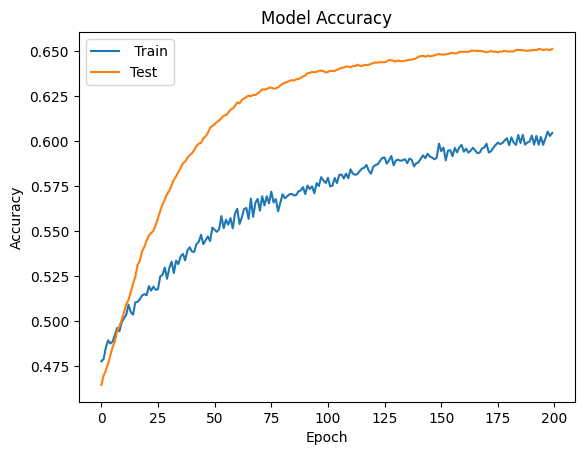

Epoch 1/200
272/272 [==============================] - 6s 9ms/step - loss: 0.6885 - accuracy: 0.6038 - precision_9: 0.6162 - recall_9: 0.6136 - val_loss: 0.6600 - val_accuracy: 0.6515 - val_precision_9: 0.6541 - val_recall_9: 0.6999
Epoch 2/200
272/272 [==============================] - 2s 8ms/step - loss: 0.6889 - accuracy: 0.6033 - precision_9: 0.6147 - recall_9: 0.6172 - val_loss: 0.6599 - val_accuracy: 0.6514 - val_precision_9: 0.6540 - val_recall_9: 0.6997
Epoch 3/200
272/272 [==============================] - 3s 10ms/step - loss: 0.6856 - accuracy: 0.6077 - precision_9: 0.6195 - recall_9: 0.6194 - val_loss: 0.6599 - val_accuracy: 0.6512 - val_precision_9: 0.6539 - val_recall_9: 0.6992
Epoch 4/200
272/272 [==============================] - 2s 6ms/step - loss: 0.6865 - accuracy: 0.6021 - precision_9: 0.6130 - recall_9: 0.6184 - val_loss: 0.6598 - val_accuracy: 0.6512 - val_precision_9: 0.6539 - val_recall_9: 0.6992
Epoch 5/200
272/272 [==============================] - 2s 7ms/step 

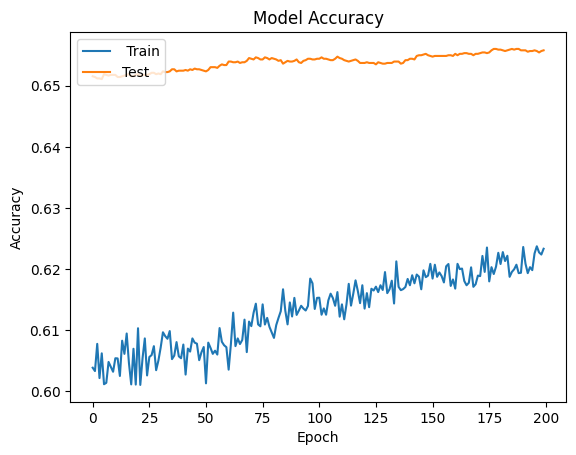

Epoch 1/200
136/136 [==============================] - 6s 16ms/step - loss: 0.6777 - accuracy: 0.6173 - precision_10: 0.6236 - recall_10: 0.6495 - val_loss: 0.6522 - val_accuracy: 0.6558 - val_precision_10: 0.6589 - val_recall_10: 0.7006
Epoch 2/200
136/136 [==============================] - 1s 8ms/step - loss: 0.6769 - accuracy: 0.6215 - precision_10: 0.6278 - recall_10: 0.6526 - val_loss: 0.6522 - val_accuracy: 0.6559 - val_precision_10: 0.6590 - val_recall_10: 0.7006
Epoch 3/200
136/136 [==============================] - 1s 8ms/step - loss: 0.6782 - accuracy: 0.6211 - precision_10: 0.6277 - recall_10: 0.6510 - val_loss: 0.6522 - val_accuracy: 0.6559 - val_precision_10: 0.6590 - val_recall_10: 0.7006
Epoch 4/200
136/136 [==============================] - 1s 8ms/step - loss: 0.6756 - accuracy: 0.6243 - precision_10: 0.6310 - recall_10: 0.6530 - val_loss: 0.6522 - val_accuracy: 0.6559 - val_precision_10: 0.6590 - val_recall_10: 0.7006
Epoch 5/200
136/136 [==============================

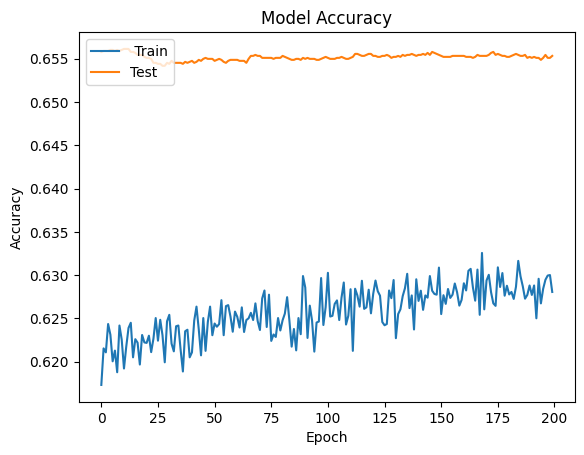

Epoch 1/200
68/68 [==============================] - 5s 21ms/step - loss: 0.6729 - accuracy: 0.6281 - precision_11: 0.6328 - recall_11: 0.6637 - val_loss: 0.6489 - val_accuracy: 0.6557 - val_precision_11: 0.6574 - val_recall_11: 0.7052
Epoch 2/200
68/68 [==============================] - 1s 13ms/step - loss: 0.6725 - accuracy: 0.6313 - precision_11: 0.6351 - recall_11: 0.6692 - val_loss: 0.6489 - val_accuracy: 0.6557 - val_precision_11: 0.6574 - val_recall_11: 0.7052
Epoch 3/200
68/68 [==============================] - 1s 12ms/step - loss: 0.6723 - accuracy: 0.6272 - precision_11: 0.6302 - recall_11: 0.6696 - val_loss: 0.6489 - val_accuracy: 0.6557 - val_precision_11: 0.6573 - val_recall_11: 0.7054
Epoch 4/200
68/68 [==============================] - 1s 12ms/step - loss: 0.6739 - accuracy: 0.6312 - precision_11: 0.6351 - recall_11: 0.6685 - val_loss: 0.6489 - val_accuracy: 0.6557 - val_precision_11: 0.6574 - val_recall_11: 0.7052
Epoch 5/200
68/68 [==============================] - 1s 

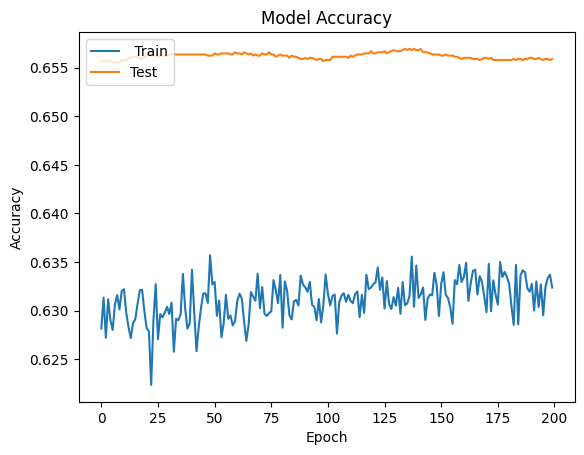

In [ ]:
# training model and evaluating scores with different batch size and optimizers and iterations
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adadelta", 200, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)

In [ ]:
# preprocessing the data and creating model with dipeptide composition features
x = dpc.values
sc = StandardScaler()
x = sc.fit_transform(x)
y = target.values
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)
model = create_model(x_train)

Epoch 1/200
544/544 [==============================] - 9s 9ms/step - loss: 0.7812 - accuracy: 0.5018 - precision_12: 0.5112 - recall_12: 0.7596 - val_loss: 0.7416 - val_accuracy: 0.5128 - val_precision_12: 0.5185 - val_recall_12: 0.8773
Epoch 2/200
544/544 [==============================] - 3s 6ms/step - loss: 0.7788 - accuracy: 0.5114 - precision_12: 0.5177 - recall_12: 0.7610 - val_loss: 0.7407 - val_accuracy: 0.5133 - val_precision_12: 0.5189 - val_recall_12: 0.8751
Epoch 3/200
544/544 [==============================] - 4s 6ms/step - loss: 0.7788 - accuracy: 0.5039 - precision_12: 0.5129 - recall_12: 0.7479 - val_loss: 0.7399 - val_accuracy: 0.5138 - val_precision_12: 0.5193 - val_recall_12: 0.8727
Epoch 4/200
544/544 [==============================] - 5s 9ms/step - loss: 0.7763 - accuracy: 0.5068 - precision_12: 0.5147 - recall_12: 0.7519 - val_loss: 0.7391 - val_accuracy: 0.5144 - val_precision_12: 0.5197 - val_recall_12: 0.8701
Epoch 5/200
544/544 [==============================]

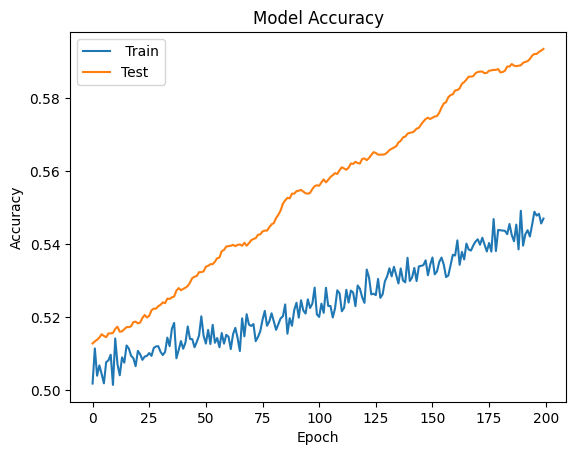

Epoch 1/200
272/272 [==============================] - 8s 13ms/step - loss: 0.7157 - accuracy: 0.5466 - precision_13: 0.5565 - recall_13: 0.5917 - val_loss: 0.7045 - val_accuracy: 0.5933 - val_precision_13: 0.6089 - val_recall_13: 0.6086
Epoch 2/200
272/272 [==============================] - 2s 8ms/step - loss: 0.7144 - accuracy: 0.5470 - precision_13: 0.5572 - recall_13: 0.5901 - val_loss: 0.7044 - val_accuracy: 0.5938 - val_precision_13: 0.6094 - val_recall_13: 0.6086
Epoch 3/200
272/272 [==============================] - 2s 9ms/step - loss: 0.7154 - accuracy: 0.5488 - precision_13: 0.5583 - recall_13: 0.5959 - val_loss: 0.7042 - val_accuracy: 0.5943 - val_precision_13: 0.6101 - val_recall_13: 0.6086
Epoch 4/200
272/272 [==============================] - 2s 9ms/step - loss: 0.7147 - accuracy: 0.5484 - precision_13: 0.5583 - recall_13: 0.5928 - val_loss: 0.7041 - val_accuracy: 0.5942 - val_precision_13: 0.6101 - val_recall_13: 0.6082
Epoch 5/200
272/272 [==============================

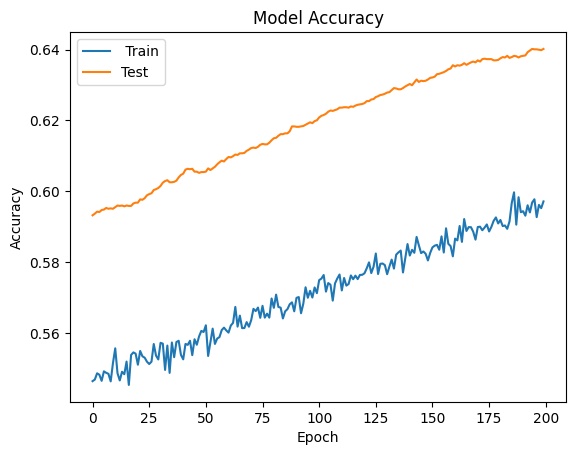

Epoch 1/200
136/136 [==============================] - 6s 15ms/step - loss: 0.6884 - accuracy: 0.5965 - precision_14: 0.6055 - recall_14: 0.6231 - val_loss: 0.6707 - val_accuracy: 0.6399 - val_precision_14: 0.6548 - val_recall_14: 0.6502
Epoch 2/200
136/136 [==============================] - 1s 10ms/step - loss: 0.6880 - accuracy: 0.5976 - precision_14: 0.6075 - recall_14: 0.6195 - val_loss: 0.6706 - val_accuracy: 0.6399 - val_precision_14: 0.6546 - val_recall_14: 0.6508
Epoch 3/200
136/136 [==============================] - 1s 10ms/step - loss: 0.6892 - accuracy: 0.5923 - precision_14: 0.6025 - recall_14: 0.6140 - val_loss: 0.6705 - val_accuracy: 0.6399 - val_precision_14: 0.6546 - val_recall_14: 0.6508
Epoch 4/200
136/136 [==============================] - 1s 11ms/step - loss: 0.6872 - accuracy: 0.5998 - precision_14: 0.6097 - recall_14: 0.6209 - val_loss: 0.6704 - val_accuracy: 0.6401 - val_precision_14: 0.6547 - val_recall_14: 0.6510
Epoch 5/200
136/136 [===========================

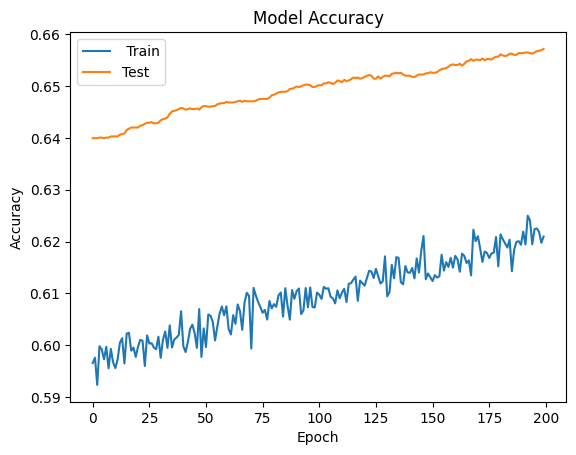

Epoch 1/200
68/68 [==============================] - 6s 24ms/step - loss: 0.6729 - accuracy: 0.6203 - precision_15: 0.6277 - recall_15: 0.6470 - val_loss: 0.6512 - val_accuracy: 0.6574 - val_precision_15: 0.6673 - val_recall_15: 0.6800
Epoch 2/200
68/68 [==============================] - 1s 16ms/step - loss: 0.6733 - accuracy: 0.6217 - precision_15: 0.6281 - recall_15: 0.6520 - val_loss: 0.6511 - val_accuracy: 0.6574 - val_precision_15: 0.6672 - val_recall_15: 0.6802
Epoch 3/200
68/68 [==============================] - 1s 16ms/step - loss: 0.6715 - accuracy: 0.6206 - precision_15: 0.6279 - recall_15: 0.6478 - val_loss: 0.6511 - val_accuracy: 0.6575 - val_precision_15: 0.6674 - val_recall_15: 0.6802
Epoch 4/200
68/68 [==============================] - 1s 15ms/step - loss: 0.6711 - accuracy: 0.6189 - precision_15: 0.6261 - recall_15: 0.6470 - val_loss: 0.6510 - val_accuracy: 0.6577 - val_precision_15: 0.6676 - val_recall_15: 0.6804
Epoch 5/200
68/68 [==============================] - 1s 

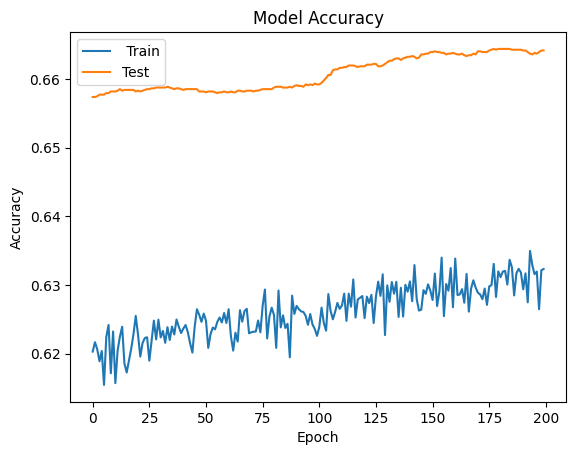

In [ ]:
# training model and evaluating scores with different batch size and optimizers and iterations
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adadelta", 200, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)

In [ ]:
# preprocessing the data and creating model with physio-chemical properties features
x = struct_pc.values
sc = StandardScaler()
x = sc.fit_transform(x)
y = target.values
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)
model = create_model(x_train)

Epoch 1/200
544/544 [==============================] - 8s 8ms/step - loss: 0.7294 - accuracy: 0.5246 - precision_16: 0.5325 - recall_16: 0.6353 - val_loss: 0.7229 - val_accuracy: 0.5483 - val_precision_16: 0.5527 - val_recall_16: 0.6869
Epoch 2/200
544/544 [==============================] - 4s 8ms/step - loss: 0.7289 - accuracy: 0.5236 - precision_16: 0.5314 - recall_16: 0.6399 - val_loss: 0.7220 - val_accuracy: 0.5530 - val_precision_16: 0.5563 - val_recall_16: 0.6924
Epoch 3/200
544/544 [==============================] - 3s 6ms/step - loss: 0.7273 - accuracy: 0.5306 - precision_16: 0.5370 - recall_16: 0.6468 - val_loss: 0.7212 - val_accuracy: 0.5558 - val_precision_16: 0.5581 - val_recall_16: 0.6997
Epoch 4/200
544/544 [==============================] - 3s 6ms/step - loss: 0.7275 - accuracy: 0.5280 - precision_16: 0.5347 - recall_16: 0.6478 - val_loss: 0.7204 - val_accuracy: 0.5579 - val_precision_16: 0.5595 - val_recall_16: 0.7030
Epoch 5/200
544/544 [==============================]

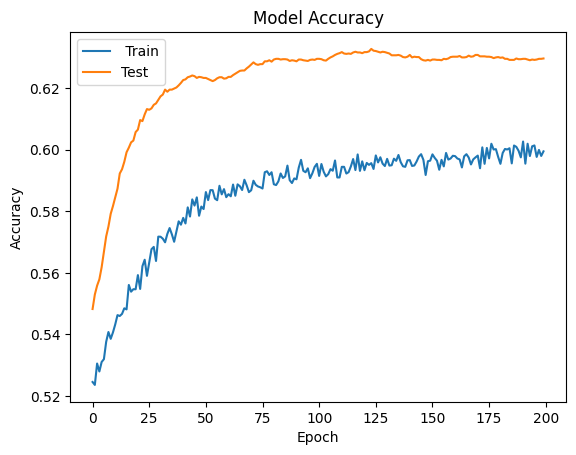

Epoch 1/200
272/272 [==============================] - 6s 8ms/step - loss: 0.6895 - accuracy: 0.6009 - precision_17: 0.5839 - recall_17: 0.7857 - val_loss: 0.6744 - val_accuracy: 0.6297 - val_precision_17: 0.6192 - val_recall_17: 0.7472
Epoch 2/200
272/272 [==============================] - 2s 6ms/step - loss: 0.6889 - accuracy: 0.6022 - precision_17: 0.5848 - recall_17: 0.7867 - val_loss: 0.6743 - val_accuracy: 0.6297 - val_precision_17: 0.6192 - val_recall_17: 0.7474
Epoch 3/200
272/272 [==============================] - 2s 6ms/step - loss: 0.6884 - accuracy: 0.6014 - precision_17: 0.5842 - recall_17: 0.7859 - val_loss: 0.6743 - val_accuracy: 0.6297 - val_precision_17: 0.6192 - val_recall_17: 0.7474
Epoch 4/200
272/272 [==============================] - 2s 6ms/step - loss: 0.6901 - accuracy: 0.5982 - precision_17: 0.5819 - recall_17: 0.7829 - val_loss: 0.6742 - val_accuracy: 0.6299 - val_precision_17: 0.6194 - val_recall_17: 0.7474
Epoch 5/200
272/272 [==============================]

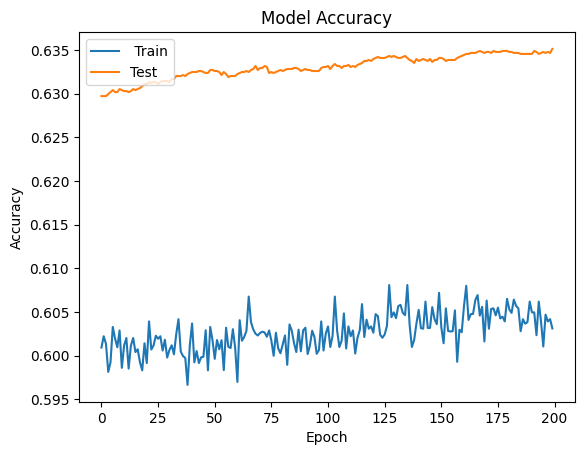

Epoch 1/200
136/136 [==============================] - 7s 14ms/step - loss: 0.6832 - accuracy: 0.6039 - precision_18: 0.5872 - recall_18: 0.7795 - val_loss: 0.6677 - val_accuracy: 0.6349 - val_precision_18: 0.6255 - val_recall_18: 0.7417
Epoch 2/200
136/136 [==============================] - 1s 9ms/step - loss: 0.6814 - accuracy: 0.6070 - precision_18: 0.5900 - recall_18: 0.7786 - val_loss: 0.6677 - val_accuracy: 0.6347 - val_precision_18: 0.6254 - val_recall_18: 0.7412
Epoch 3/200
136/136 [==============================] - 1s 9ms/step - loss: 0.6836 - accuracy: 0.6074 - precision_18: 0.5898 - recall_18: 0.7823 - val_loss: 0.6677 - val_accuracy: 0.6350 - val_precision_18: 0.6257 - val_recall_18: 0.7417
Epoch 4/200
136/136 [==============================] - 1s 9ms/step - loss: 0.6821 - accuracy: 0.6051 - precision_18: 0.5885 - recall_18: 0.7777 - val_loss: 0.6677 - val_accuracy: 0.6350 - val_precision_18: 0.6257 - val_recall_18: 0.7417
Epoch 5/200
136/136 [==============================

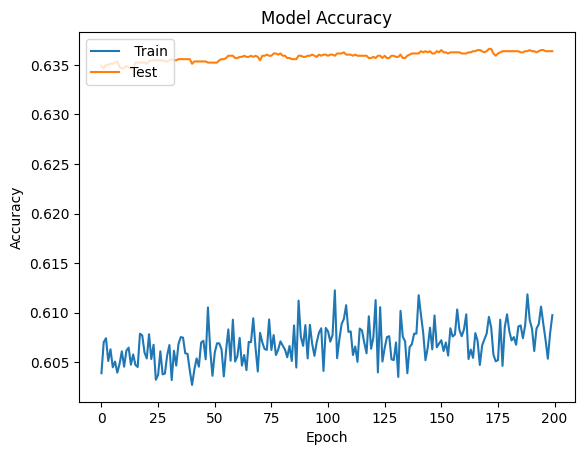

Epoch 1/200
68/68 [==============================] - 5s 25ms/step - loss: 0.6795 - accuracy: 0.6091 - precision_19: 0.5925 - recall_19: 0.7739 - val_loss: 0.6648 - val_accuracy: 0.6364 - val_precision_19: 0.6278 - val_recall_19: 0.7381
Epoch 2/200
68/68 [==============================] - 1s 20ms/step - loss: 0.6787 - accuracy: 0.6096 - precision_19: 0.5931 - recall_19: 0.7730 - val_loss: 0.6648 - val_accuracy: 0.6364 - val_precision_19: 0.6278 - val_recall_19: 0.7381
Epoch 3/200
68/68 [==============================] - 1s 20ms/step - loss: 0.6807 - accuracy: 0.6062 - precision_19: 0.5907 - recall_19: 0.7682 - val_loss: 0.6648 - val_accuracy: 0.6364 - val_precision_19: 0.6278 - val_recall_19: 0.7381
Epoch 4/200
68/68 [==============================] - 1s 15ms/step - loss: 0.6801 - accuracy: 0.6087 - precision_19: 0.5926 - recall_19: 0.7703 - val_loss: 0.6647 - val_accuracy: 0.6364 - val_precision_19: 0.6278 - val_recall_19: 0.7381
Epoch 5/200
68/68 [==============================] - 1s 

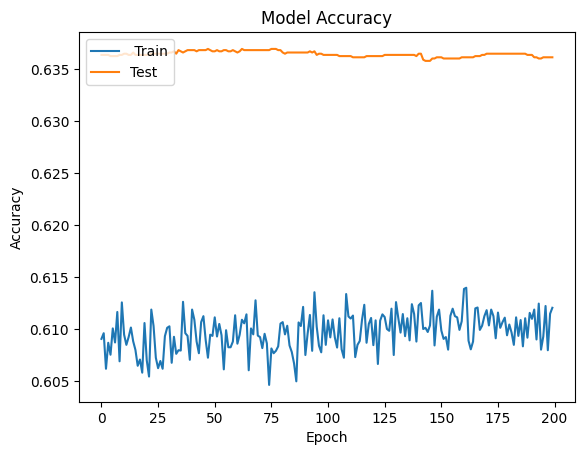

In [ ]:
# training model and evaluating scores with different batch size and optimizers and iterations
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adadelta", 200, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/rdkit_dataset.csv') # loading rdkit dataset

In [ ]:
data # showing dataset

,MolWt,NumRotatableBonds,TPSA,AUTOCORR2D_1,AUTOCORR2D_2,AUTOCORR2D_3,AUTOCORR2D_4,AUTOCORR2D_5,AUTOCORR2D_6,AUTOCORR2D_7,...,AUTOCORR2D_182,AUTOCORR2D_183,AUTOCORR2D_184,AUTOCORR2D_185,AUTOCORR2D_186,AUTOCORR2D_187,AUTOCORR2D_188,AUTOCORR2D_189,qed,Target
0,1776.113,60.0,701.14,14.729097,0.060103,-2.080788,0.021793,15.138211,1776.113,1649.105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021793,0
1,1738.874,57.0,832.01,14.566415,0.044381,-2.170827,0.016357,16.352459,1738.874,1618.922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016357,0
2,1677.925,51.0,676.94,14.402321,0.029760,-1.806985,0.016682,16.504202,1677.925,1556.965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016682,0
3,1710.150,59.0,667.71,14.676367,0.005836,-1.634398,0.013024,15.364407,1710.150,1577.094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013024,1
4,1858.098,53.0,766.93,14.709878,0.005817,-2.152389,0.008452,16.384615,1858.098,1741.170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008452,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57230,1640.855,48.0,612.33,14.773368,0.010197,-1.973330,0.019602,15.623932,1640.855,1526.951,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019602,1
57231,1875.308,57.0,663.32,15.220414,0.032724,-1.771628,0.008432,15.969697,1875.308,1743.260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008432,0
57232,1782.131,63.0,852.17,14.643091,0.010002,-1.943594,0.015273,15.480000,1782.131,1641.011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015273,0
57233,1794.957,54.0,860.69,14.849205,0.002266,-2.057832,0.016611,17.401575,1794.957,1675.005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.016611,1


In [ ]:
# preprocessing the data and creating model with rdkit dataset
x = data.drop(['Target'], axis=1).values
sc = StandardScaler()
x = sc.fit_transform(x)
y = data['Target'].values
x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, y)
model = create_model(x_train)

In [ ]:
# training model and evaluating scores with different batch size and optimizers and iterations
batch = [64, 128, 256, 512]
for batch_size in batch:
  hist = train(model, "adadelta", 200, batch_size, x_train, y_train, x_val, y_val)
  evaluate_score(model, x_test, y_test)
  plot(hist)